Using random forest regressor instead of the linear regressor in ML3.3.8

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def in_out(auxhist, wrfout): #outputs the required input and output data from the auxhist and wrfout files
    DS_a = xr.open_dataset(auxhist) #dataset of auxhist
    DS_w = xr.open_dataset(wrfout) #dataset of wrfout
    
    T = (DS_w.T.values + DS_w.T0) * ((DS_w.P.values + DS_w.PB.values)/DS_w.P0)**(DS_w.R_D/DS_w.CP)
    st = DS_w.TSK.values #surface temp
    d_c = DS_w.TAU_OD.values #dust optical depth
    em = DS_w.EMISS.values #emissivity
    p = DS_w.P.values + DS_w.PB.values #pressure
    uif = DS_a.UPIRFLUX.values[1:,:,:,:] 

    temp_uif = []
    for i in range(52):
        temp_uif.append(uif[:,i,:,:].reshape(-1))
    uif = np.array(temp_uif).T
    uif.shape


    sla = [] #special layer arrays that are the feature vectors in the linear regression model
    sla.append((em*st**4).reshape(-1)) #don't have overall opacity, will deal with this issue later
    for i in range(52): #using all the layers now
        sla.append((np.exp(-d_c[:,i,:,:])*T[:,i,:,:]**4).reshape(-1))
    for i in range(52): #using all the layers now
        sla.append((np.exp(-p[:,i,:,:])*T[:,i,:,:]**4).reshape(-1))
    sla = np.array(sla)
    sla = sla.T[2592:,:] #take transpose, remove first day of data (all lwr are 0 there)
    
    return sla, uif

In [3]:
sla_summer, uif_summer = in_out('af_summer', 'wf_summer')  #first snapshot of data (0002-00172), summer

In [4]:
sla_fall, uif_fall = in_out('af_fall', 'wf_fall') #(0002-00352), fall

In [5]:
sla_winter, uif_winter = in_out('af_winter', 'wf_winter') #(0002-00352), winter 

In [6]:
sla_spring, uif_spring = in_out('af_spring', 'wf_spring') #(0002-00652), spring 

In [7]:
sla_test_set, uif_test_set = in_out("af_test", "wf_test") #(0002-00472), testing on this as well to check if overfit

In [8]:
uif_train = np.concatenate((uif_summer, uif_fall, uif_winter, uif_spring), axis=0) #total uif for training

In [9]:
sla_train = np.concatenate((sla_summer, sla_fall, sla_winter, sla_spring), axis=0) #total sla for training

In [10]:
from sklearn.model_selection import train_test_split
sla_train, sla_test, uif_train, uif_test = train_test_split(sla_train, uif_train, test_size=0.99, random_state=42)

In [11]:
uif_train.shape

(22705, 52)

# Predicting Summer:

In [12]:
from sklearn.ensemble import RandomForestRegressor
rfr1 = RandomForestRegressor()
rfr1.fit(sla_train,uif_train)
uif_lin = rfr1.predict(sla_summer)  
uif_out = uif_summer

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [13]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

2.789274475653315

In [14]:
np.min(uif_out)

17.541994

In [15]:
np.max(uif_out)

339.41235

In [16]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

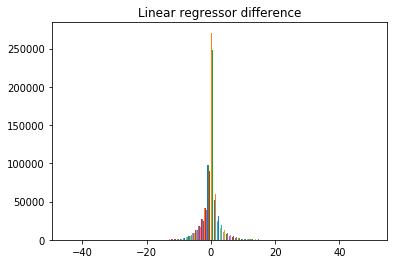

In [17]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [18]:
uif_out.reshape(-1,1).shape

(32213376, 1)

In [19]:
real_out = uif_out[10*36*72:11*36*72,10].reshape(36,72)
pred_out = uif_lin[10*36*72:11*36*72,10].reshape(36,72)

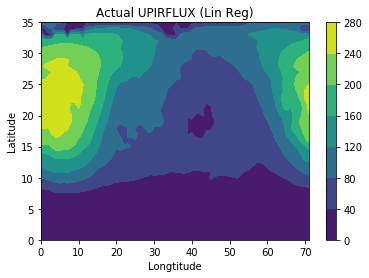

In [20]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

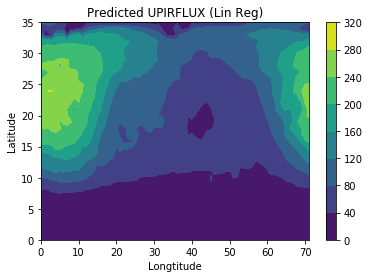

In [21]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

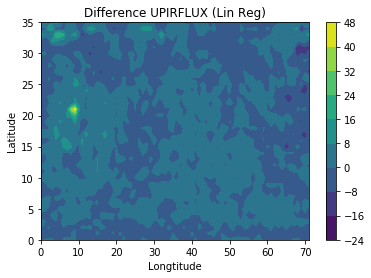

In [22]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

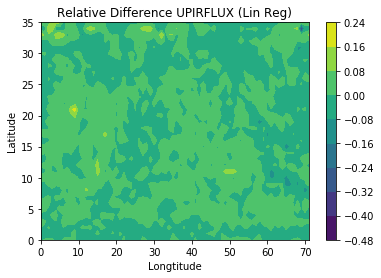

In [23]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [24]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [25]:
real_out.shape

(36, 72)

In [26]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [27]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[ 0.20366694, -0.06743109,  0.12467505, ...,  0.00423859,
         0.2194638 , -0.07233329],
       [ 0.20366006, -0.06743118,  0.12466472, ...,  0.00422693,
         0.21945803, -0.0723319 ],
       [ 0.20365546, -0.06743128,  0.12465734, ...,  0.00421858,
         0.21945396, -0.07233078],
       ...,
       [ 0.75718739,  0.22937044,  0.47598753, ...,  0.3859796 ,
         0.6665399 ,  0.12788226],
       [ 0.75636342,  0.22229483,  0.47061593, ...,  0.38450944,
         0.66341032,  0.12110017],
       [ 0.74490012,  0.20527701,  0.45643603, ...,  0.37893269,
         0.65158051,  0.10777443]])

In [28]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([0.3430348 , 0.34302692, 0.34302155, 0.34299111, 0.34288373,
       0.34274604, 0.34265523, 0.34237827, 0.34195907, 0.34173079,
       0.34186295, 0.34202148, 0.34173728, 0.34111137, 0.34049421,
       0.3399453 , 0.33911502, 0.33749363, 0.33531758, 0.33303318,
       0.33117526, 0.33113668, 0.33447921, 0.34282876, 0.35638904,
       0.37464643, 0.39464592, 0.41327981, 0.43224307, 0.45252986,
       0.47260213, 0.48706095, 0.49655701, 0.50381133, 0.52039705,
       0.56438201, 0.62464821, 0.68174051, 0.73104117, 0.75095043,
       0.77155664, 0.78439113, 0.7976471 , 0.81096902, 0.82391294,
       0.8325372 , 0.84161628, 0.85101908, 0.85930364, 0.86334549,
       0.8587613 , 0.84173015])

In [29]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([-0.17833465, -0.17833421, -0.17833393, -0.1783675 , -0.17838363,
       -0.17834707, -0.17842028, -0.17848446, -0.17845332, -0.17845324,
       -0.17868379, -0.17893347, -0.17904636, -0.17932427, -0.18013019,
       -0.1814057 , -0.18281505, -0.18433208, -0.18630631, -0.18906756,
       -0.19167537, -0.19259609, -0.19033815, -0.18324181, -0.17134152,
       -0.15649262, -0.14227207, -0.13227719, -0.12686253, -0.1235568 ,
       -0.11831568, -0.11143853, -0.10608616, -0.10256921, -0.09107555,
       -0.06261381, -0.02657587,  0.01098568,  0.0375376 ,  0.04270143,
        0.04555851,  0.04665438,  0.04747393,  0.04799365,  0.04748744,
        0.04590822,  0.04286355,  0.03830562,  0.03186293,  0.02342461,
        0.01412977, -0.00317335])

In [30]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.12911299, 0.12911081, 0.12910931, 0.12911508, 0.12909344,
       0.1290367 , 0.129046  , 0.12895732, 0.12881026, 0.1287684 ,
       0.12887629, 0.12900192, 0.12900721, 0.12896069, 0.12901006,
       0.12915254, 0.12925018, 0.12916375, 0.12899679, 0.1290039 ,
       0.12919273, 0.12945822, 0.12985436, 0.13038979, 0.13096059,
       0.13175719, 0.13318377, 0.13551697, 0.13890219, 0.14344493,
       0.14815045, 0.15148598, 0.15372173, 0.15552683, 0.15822088,
       0.16409635, 0.17101717, 0.17544317, 0.18033012, 0.18392312,
       0.18833472, 0.19112001, 0.19390766, 0.19687399, 0.20052206,
       0.2037552 , 0.20778467, 0.21253945, 0.21784296, 0.2225259 ,
       0.22467266, 0.22589621])

In [31]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([0.06892317, 0.06891634, 0.06891153, 0.06887607, 0.06879482,
       0.06868249, 0.06855109, 0.06836545, 0.06818964, 0.06804994,
       0.0679356 , 0.06781866, 0.06760942, 0.06726696, 0.06673067,
       0.06591506, 0.06478157, 0.06328308, 0.06149541, 0.05939633,
       0.05728117, 0.05633788, 0.05838877, 0.06543335, 0.07791423,
       0.09453084, 0.11192226, 0.12728957, 0.14129314, 0.15451441,
       0.16642964, 0.17438158, 0.17971742, 0.18615117, 0.20375884,
       0.2434844 , 0.29456844, 0.34324941, 0.38146492, 0.39436963,
       0.40634864, 0.41318579, 0.41987054, 0.42663382, 0.43342839,
       0.43789121, 0.44191174, 0.44503254, 0.44654831, 0.44554915,
       0.44090344, 0.42901573])

In [32]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
0.1930248789691097


# Predicting Fall:

In [33]:
uif_lin = rfr1.predict(sla_fall) 
uif_out = uif_fall

In [34]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

3.7422896935357954

In [35]:
np.min(uif_out)

15.713927

In [36]:
np.max(uif_out)

484.24545

In [37]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

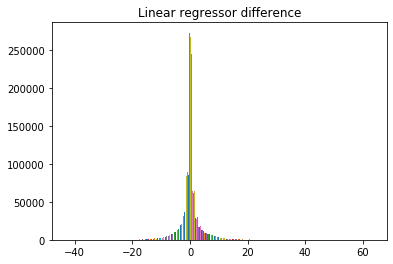

In [38]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [39]:
uif_out.reshape(-1,1).shape

(32213376, 1)

In [40]:
real_out = uif_out[10*36*72:11*36*72,10].reshape(36,72)
pred_out = uif_lin[10*36*72:11*36*72,10].reshape(36,72)

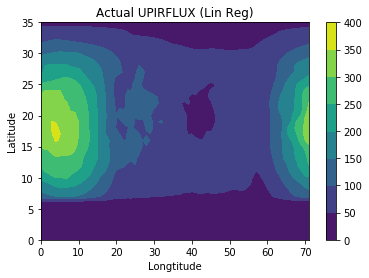

In [41]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

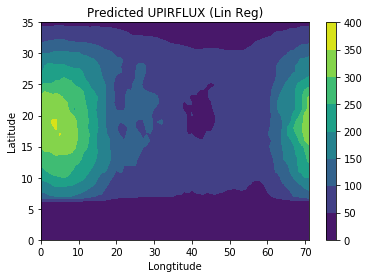

In [42]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

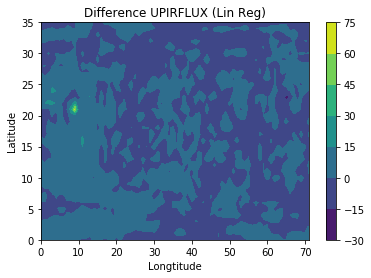

In [43]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

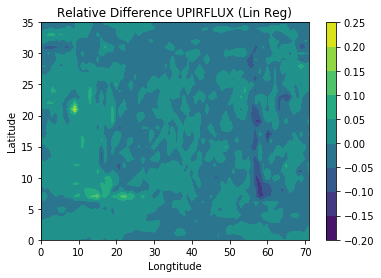

In [44]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [45]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [46]:
real_out.shape

(36, 72)

In [47]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [48]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[ 0.00669681, -0.41070258,  0.25708883, ..., -0.29132589,
         0.01786101, -0.31095195],
       [ 0.00669924, -0.41069997,  0.25709867, ..., -0.29132351,
         0.01786501, -0.31094171],
       [ 0.0067011 , -0.41069812,  0.25710654, ..., -0.29132214,
         0.01786816, -0.31093426],
       ...,
       [-0.28446307, -0.99316711, -0.27978285, ..., -0.65154222,
        -0.23907388, -0.80619477],
       [-0.29142603, -0.99369749, -0.27407446, ..., -0.62556348,
        -0.24460689, -0.81317245],
       [-0.27696946, -1.00658686, -0.24547169, ..., -0.58360395,
        -0.23250831, -0.8333612 ]])

In [49]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([0.51384967, 0.51385776, 0.51386345, 0.51400892, 0.51417631,
       0.51406525, 0.51418909, 0.51445427, 0.51454776, 0.51405467,
       0.51360376, 0.51320948, 0.51271686, 0.51219112, 0.51203606,
       0.51239613, 0.51305148, 0.51382935, 0.51437706, 0.51418829,
       0.51239989, 0.50804871, 0.50042336, 0.48849525, 0.47240649,
       0.45264045, 0.42993992, 0.40170225, 0.36830033, 0.33271637,
       0.29455311, 0.25290838, 0.21334713, 0.18274792, 0.16314696,
       0.14166166, 0.11334324, 0.08079507, 0.05453419, 0.04795322,
       0.04547444, 0.04595993, 0.04781525, 0.05079731, 0.05382256,
       0.05488147, 0.05472952, 0.05261973, 0.04843867, 0.04583129,
       0.05333485, 0.07944735])

In [50]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([-0.54594857, -0.54594828, -0.54594813, -0.54597775, -0.54601424,
       -0.54603876, -0.54606169, -0.54625085, -0.54643315, -0.54606594,
       -0.54547769, -0.54533432, -0.54587436, -0.54667394, -0.54728044,
       -0.54750613, -0.54708912, -0.54572606, -0.54368786, -0.5417453 ,
       -0.5411511 , -0.54436565, -0.55168315, -0.56406532, -0.58201088,
       -0.60610663, -0.63547596, -0.67018526, -0.70918414, -0.75058454,
       -0.79362388, -0.8381006 , -0.88007835, -0.91733163, -0.95402838,
       -0.99564125, -1.03438433, -1.07356577, -1.10739751, -1.12145615,
       -1.13550023, -1.14404358, -1.15269003, -1.16034034, -1.16650995,
       -1.16958555, -1.17164752, -1.17286814, -1.17363518, -1.17291933,
       -1.17444372, -1.18305128])

In [51]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.31527856, 0.31528096, 0.31528284, 0.31533834, 0.31540274,
       0.31537019, 0.31535006, 0.31541952, 0.31548739, 0.3153846 ,
       0.31516124, 0.31484014, 0.31466861, 0.31473412, 0.31500048,
       0.31524519, 0.31523387, 0.31490486, 0.31433361, 0.31365744,
       0.31304168, 0.31264808, 0.31251425, 0.3125194 , 0.31261665,
       0.31300856, 0.31372675, 0.31394282, 0.31355664, 0.31302673,
       0.3121699 , 0.31079164, 0.30916274, 0.30699655, 0.3066676 ,
       0.3090713 , 0.30969976, 0.30862804, 0.31015142, 0.31286124,
       0.3170434 , 0.32021096, 0.32381183, 0.32748811, 0.33103327,
       0.33306419, 0.3345812 , 0.33514275, 0.33410399, 0.33129338,
       0.33019746, 0.33865107])

In [52]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([-0.10449328, -0.10448928, -0.10448628, -0.10443991, -0.1043973 ,
       -0.10452653, -0.10452439, -0.10439005, -0.10416534, -0.10404293,
       -0.10411705, -0.10442304, -0.10476181, -0.10511012, -0.1054665 ,
       -0.10556333, -0.10503067, -0.10379343, -0.1023049 , -0.10126002,
       -0.10176466, -0.10502406, -0.11199545, -0.12361261, -0.13969165,
       -0.16024158, -0.18421788, -0.2126216 , -0.24483102, -0.27867313,
       -0.31238328, -0.34585192, -0.37668946, -0.40432907, -0.42906712,
       -0.45487231, -0.47847472, -0.50027592, -0.51771279, -0.52255043,
       -0.52639272, -0.52861285, -0.53075543, -0.53265654, -0.53433596,
       -0.53543248, -0.53651868, -0.53750791, -0.5379727 , -0.53689755,
       -0.53050788, -0.51278719])

In [53]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
-0.2782893218225205


# Predicting Winter:

In [54]:
uif_lin = rfr1.predict(sla_winter)  
uif_out = uif_winter

In [55]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

5.356526811761598

In [56]:
np.min(uif_out)

15.832658

In [57]:
np.max(uif_out)

485.98044

In [58]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

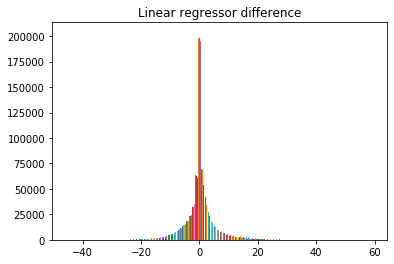

In [59]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [60]:
uif_out.reshape(-1,1).shape

(32213376, 1)

In [61]:
real_out = uif_out[10*36*72:11*36*72,10].reshape(36,72)
pred_out = uif_lin[10*36*72:11*36*72,10].reshape(36,72)

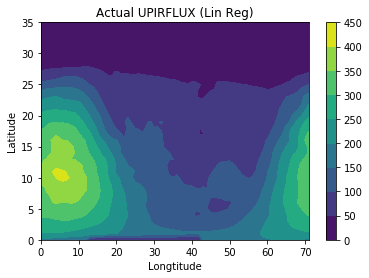

In [62]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

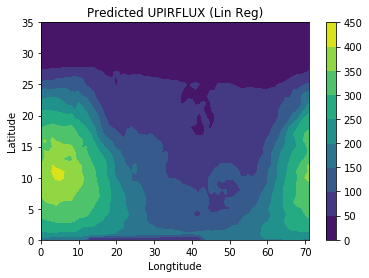

In [63]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

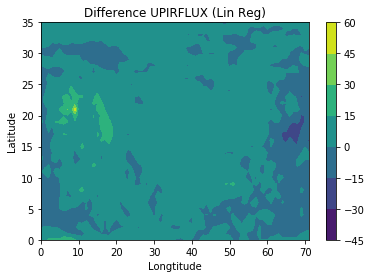

In [64]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

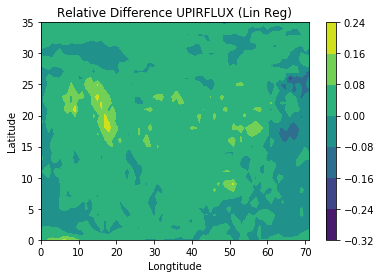

In [65]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [66]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [67]:
real_out.shape

(36, 72)

In [68]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [69]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[1.82010286, 2.27812648, 2.17408906, ..., 1.1509926 , 0.91793163,
        1.27180322],
       [1.82007379, 2.27809448, 2.17405257, ..., 1.15098037, 0.91791354,
        1.27176431],
       [1.82005379, 2.27807109, 2.17402667, ..., 1.15097146, 0.91789986,
        1.27173491],
       ...,
       [2.8665027 , 2.95290357, 2.74588431, ..., 1.87335802, 1.57622639,
        1.58156082],
       [2.83210442, 2.91621601, 2.71200273, ..., 1.87659534, 1.57388862,
        1.58528779],
       [2.78505051, 2.84475335, 2.67733674, ..., 1.88286718, 1.56681675,
        1.56037065]])

In [70]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([2.27812648, 2.27809448, 2.27807109, 2.27800094, 2.2777194 ,
       2.27743787, 2.27629068, 2.27441038, 2.27284706, 2.27252419,
       2.27371933, 2.27655415, 2.28143725, 2.28809308, 2.29490615,
       2.30018773, 2.30490241, 2.31040804, 2.31565545, 2.32032949,
       2.3258602 , 2.3348533 , 2.35053665, 2.37703488, 2.41472643,
       2.45826835, 2.50528978, 2.55869162, 2.61688932, 2.67645615,
       2.73914069, 2.80798335, 2.88369628, 2.96769253, 3.06126697,
       3.14153061, 3.1702467 , 3.16637089, 3.15090989, 3.13338431,
       3.10719139, 3.08748842, 3.06453772, 3.04013812, 3.01756223,
       3.00530655, 2.99547796, 2.98619645, 2.97347745, 2.95290357,
       2.91621601, 2.84475335])

In [71]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([0.91793163, 0.91791354, 0.91789986, 0.91765671, 0.91746616,
       0.91762716, 0.91805752, 0.91841265, 0.9185826 , 0.91849298,
       0.91843302, 0.91865638, 0.91956291, 0.92192149, 0.92544641,
       0.92830388, 0.92981479, 0.93114193, 0.93233707, 0.93265565,
       0.9357106 , 0.94884548, 0.97255793, 1.00049972, 1.02736481,
       1.05449321, 1.08536771, 1.12269159, 1.16751568, 1.21987494,
       1.27915271, 1.34248703, 1.41047559, 1.47966994, 1.52561314,
       1.53199103, 1.51547603, 1.50896007, 1.51298448, 1.51573995,
       1.52144265, 1.51946654, 1.50504531, 1.48924624, 1.47201498,
       1.46079573, 1.44929119, 1.43608178, 1.42099395, 1.40812502,
       1.39931117, 1.39849141])

In [72]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.2754076 , 0.2754029 , 0.27539974, 0.27540066, 0.27535965,
       0.27523349, 0.274923  , 0.27444689, 0.27397142, 0.27378294,
       0.27411951, 0.27507708, 0.27654988, 0.27810337, 0.2790893 ,
       0.27931973, 0.27940075, 0.27961898, 0.27962888, 0.2796141 ,
       0.28008935, 0.28094137, 0.28197498, 0.28405234, 0.28820639,
       0.29372551, 0.29910368, 0.30429746, 0.30970834, 0.31567603,
       0.322398  , 0.32929413, 0.33599861, 0.34322873, 0.35261022,
       0.36505875, 0.37745882, 0.3885578 , 0.39680456, 0.39920963,
       0.40061436, 0.40073644, 0.4002327 , 0.39914227, 0.39771614,
       0.396852  , 0.39620096, 0.39523045, 0.39333529, 0.39003812,
       0.38502704, 0.37583331])

In [73]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([1.5348755 , 1.53484589, 1.53482431, 1.53461234, 1.53427826,
       1.53397217, 1.53382787, 1.53357522, 1.53330341, 1.53337171,
       1.53400447, 1.53524691, 1.53715541, 1.53972842, 1.54301337,
       1.54688981, 1.55097259, 1.55506632, 1.55928707, 1.56476984,
       1.57333449, 1.58662505, 1.60492571, 1.62829433, 1.65656812,
       1.69011158, 1.73001386, 1.7776896 , 1.83152728, 1.8893426 ,
       1.95080179, 2.01694051, 2.08765328, 2.16034053, 2.22459718,
       2.26771464, 2.28203917, 2.28186003, 2.27777964, 2.27148841,
       2.26227154, 2.25535352, 2.24653554, 2.23547306, 2.22285681,
       2.21488507, 2.20804863, 2.20100298, 2.19178817, 2.18024139,
       2.16608925, 2.1421355 ])

In [74]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
1.8485375027307491


# Predicting Spring:

In [75]:
uif_lin = rfr1.predict(sla_spring)
uif_out = uif_spring

In [76]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

3.2016690363031173

In [77]:
np.min(uif_out)

15.936197

In [78]:
np.max(uif_out)

414.86307

In [79]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

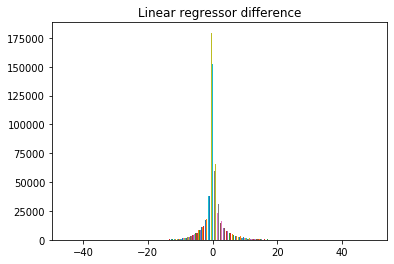

In [80]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [81]:
uif_out.reshape(-1,1).shape

(21430656, 1)

In [82]:
real_out = uif_out[10*36*72:11*36*72,10].reshape(36,72)
pred_out = uif_lin[10*36*72:11*36*72,10].reshape(36,72)

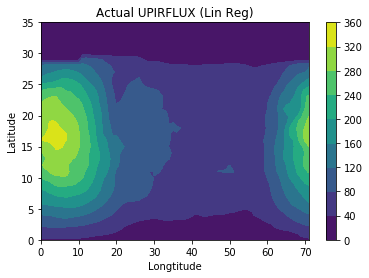

In [83]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

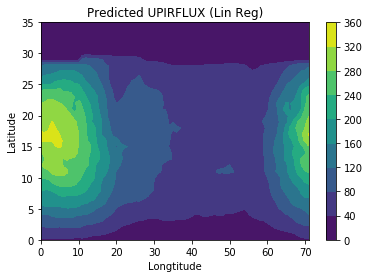

In [84]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

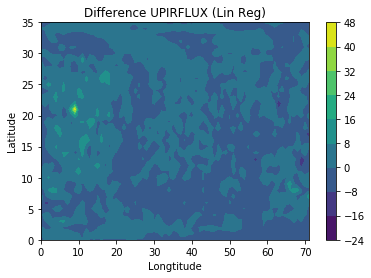

In [85]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

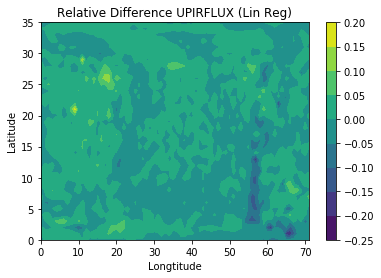

In [86]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [87]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [88]:
real_out.shape

(36, 72)

In [89]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [90]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[ 0.18659557, -0.33979219,  0.38218783, ...,  0.29361999,
         0.24775102,  0.0621252 ],
       [ 0.18659875, -0.33979017,  0.3821917 , ...,  0.29361928,
         0.24775327,  0.06212182],
       [ 0.18660128, -0.33978876,  0.38219435, ...,  0.29361857,
         0.24775528,  0.06211907],
       ...,
       [ 0.27207097, -0.49236028,  0.12074907, ...,  0.49986771,
         0.45824863,  0.04050642],
       [ 0.272508  , -0.49226778,  0.14006817, ...,  0.51450643,
         0.4488833 ,  0.03914222],
       [ 0.27823621, -0.51322403,  0.16777016, ...,  0.53915794,
         0.44573638,  0.01867123]])

In [91]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([0.58001991, 0.58002679, 0.58003214, 0.58014054, 0.58033511,
       0.58043262, 0.58061223, 0.58039418, 0.57953574, 0.57876788,
       0.57849794, 0.57857707, 0.57854826, 0.57813125, 0.57736924,
       0.57650721, 0.57563218, 0.57459141, 0.57377972, 0.57377814,
       0.57447568, 0.57487774, 0.57345747, 0.56865811, 0.56005214,
       0.54794259, 0.53400465, 0.51992001, 0.50665056, 0.49430365,
       0.4830695 , 0.47195763, 0.46068672, 0.45277897, 0.44859226,
       0.44120353, 0.426028  , 0.43266873, 0.46421204, 0.47653273,
       0.50033436, 0.51587439, 0.53166484, 0.54764034, 0.5637636 ,
       0.57518919, 0.58737329, 0.59900714, 0.60698678, 0.60799079,
       0.60443171, 0.59836243])

In [92]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([-0.33979219, -0.33979017, -0.33978876, -0.3397433 , -0.33964071,
       -0.33955504, -0.33941689, -0.33961135, -0.34010256, -0.34089052,
       -0.34144606, -0.3415554 , -0.34162783, -0.34190692, -0.34213661,
       -0.34234174, -0.34281623, -0.34349064, -0.34383019, -0.34379415,
       -0.34370408, -0.3440883 , -0.3459033 , -0.35017321, -0.35697637,
       -0.36579508, -0.37562902, -0.38552129, -0.39563445, -0.40732452,
       -0.41905676, -0.42851055, -0.43313454, -0.43738588, -0.44759547,
       -0.46567781, -0.49031773, -0.50346703, -0.50409128, -0.50481564,
       -0.505763  , -0.5059408 , -0.50607868, -0.50655626, -0.50774473,
       -0.50812995, -0.50716603, -0.50398938, -0.49792788, -0.49236028,
       -0.49226778, -0.51322403])

In [93]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.23290153, 0.2329036 , 0.23290521, 0.23291987, 0.23295453,
       0.23299406, 0.23296647, 0.2329474 , 0.23287968, 0.23290028,
       0.23293965, 0.23292248, 0.23292761, 0.23299228, 0.23305039,
       0.23305851, 0.23302206, 0.23294782, 0.23287358, 0.23291609,
       0.23309505, 0.23322563, 0.2331266 , 0.23290649, 0.23264745,
       0.23217313, 0.23158536, 0.23110369, 0.23099036, 0.23160462,
       0.23275042, 0.23363541, 0.2332616 , 0.23243826, 0.23367789,
       0.23855409, 0.24595154, 0.25383256, 0.26182523, 0.26645766,
       0.27202631, 0.2755576 , 0.27924207, 0.28305529, 0.28686895,
       0.2890116 , 0.29024012, 0.29020929, 0.28897755, 0.28723256,
       0.28874719, 0.30101728])

In [94]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([0.18597532, 0.18597746, 0.18597909, 0.18602594, 0.18608078,
       0.18598581, 0.18590637, 0.18579607, 0.18566325, 0.18550261,
       0.18530163, 0.18518209, 0.18506753, 0.18480355, 0.18440516,
       0.18388224, 0.18316382, 0.18231729, 0.18186574, 0.18234342,
       0.18370091, 0.18495486, 0.1844215 , 0.18089657, 0.17440139,
       0.16565053, 0.15624387, 0.14758405, 0.13951115, 0.13109857,
       0.12426412, 0.12160777, 0.12341595, 0.12554536, 0.12418044,
       0.11945405, 0.11196231, 0.11249773, 0.12146135, 0.12701848,
       0.13398078, 0.13892917, 0.14422981, 0.14964142, 0.15493834,
       0.15850293, 0.16223129, 0.16664853, 0.17207291, 0.177652  ,
       0.18569703, 0.19580367])

In [95]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
0.16341200039923437


# Last test set:

In [96]:
uif_lin = rfr1.predict(sla_test_set)
uif_out = uif_test_set

In [97]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

9.972296591798408

In [98]:
np.min(uif_out)

16.084946

In [99]:
np.max(uif_out)

489.8716

In [100]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

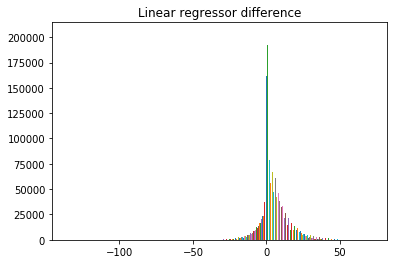

In [101]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [102]:
uif_out.reshape(-1,1).shape

(32213376, 1)

In [103]:
real_out = uif_out[10*36*72:11*36*72,10].reshape(36,72)
pred_out = uif_lin[10*36*72:11*36*72,10].reshape(36,72)

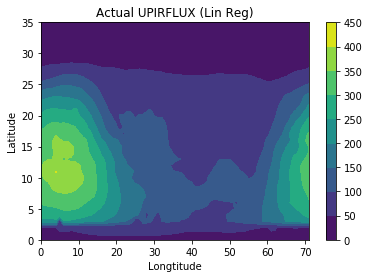

In [104]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

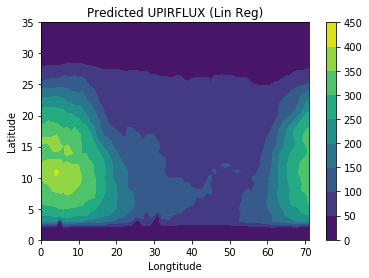

In [105]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

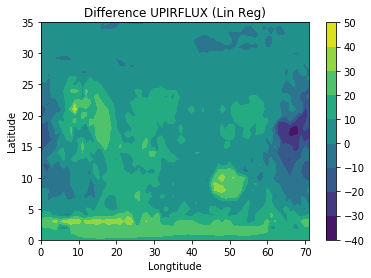

In [106]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

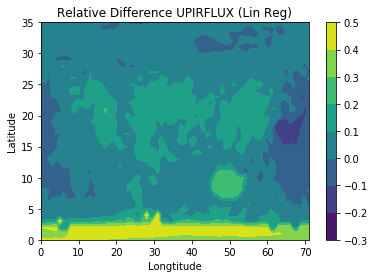

In [107]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [108]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [109]:
real_out.shape

(36, 72)

In [110]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [111]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[5.17420612, 5.51735366, 5.2849432 , ..., 4.40692253, 4.87143605,
        5.15978999],
       [5.17421977, 5.5173485 , 5.28494476, ..., 4.40688832, 4.8713732 ,
        5.15975028],
       [5.17422897, 5.51734277, 5.2849447 , ..., 4.40686426, 4.87132765,
        5.15972244],
       ...,
       [7.52049572, 6.93489279, 7.10981286, ..., 6.17781869, 6.98697041,
        6.4502132 ],
       [7.42176606, 6.83428641, 7.00283705, ..., 6.10715236, 6.91218053,
        6.34458761],
       [7.30469671, 6.68323311, 6.9026712 , ..., 6.02542502, 6.8067616 ,
        6.19045135]])

In [112]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([5.75117223, 5.75113915, 5.75111316, 5.75080482, 5.7504865 ,
       5.75115342, 5.75257552, 5.75456001, 5.75674584, 5.7587102 ,
       5.76049379, 5.76233269, 5.76385097, 5.76575363, 5.77059567,
       5.78020121, 5.79470931, 5.81333213, 5.83247348, 5.84683102,
       5.85733422, 5.87022412, 5.89245774, 5.9304221 , 5.99068376,
       6.07335074, 6.17167129, 6.27802475, 6.38182662, 6.48071155,
       6.58566382, 6.69708458, 6.81704892, 6.95508443, 7.13321473,
       7.33815678, 7.50962762, 7.69457033, 7.81486029, 7.84028209,
       7.85698291, 7.86300009, 7.8639196 , 7.85893454, 7.84655123,
       7.83374031, 7.81533957, 7.78911058, 7.74914972, 7.68889237,
       7.60249247, 7.49245231])

In [113]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([4.40692253, 4.40688832, 4.40686426, 4.40669531, 4.40627905,
       4.40544692, 4.40455628, 4.40354885, 4.40304348, 4.40426991,
       4.40763356, 4.41343843, 4.42219311, 4.43296517, 4.44319813,
       4.45207922, 4.46059824, 4.46929204, 4.4792047 , 4.49340108,
       4.51455941, 4.54388501, 4.58287345, 4.63488322, 4.6948479 ,
       4.75931885, 4.83640668, 4.93089819, 5.03092685, 5.12957265,
       5.24581505, 5.38677888, 5.53458886, 5.68618493, 5.86630402,
       6.1016461 , 6.32944377, 6.48736085, 6.55237772, 6.55159985,
       6.53792174, 6.52224066, 6.49699154, 6.46112345, 6.4162704 ,
       6.38294627, 6.3488544 , 6.30741035, 6.2493096 , 6.17781869,
       6.10715236, 6.02542502])

In [114]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.30783963, 0.30783991, 0.30783956, 0.30782723, 0.30786757,
       0.30816314, 0.3086805 , 0.30936518, 0.30990374, 0.31004848,
       0.30974984, 0.30893917, 0.30749097, 0.30562592, 0.30414658,
       0.30383289, 0.30462133, 0.30595022, 0.30749179, 0.30871204,
       0.30874938, 0.30706543, 0.30309652, 0.2982078 , 0.29596459,
       0.29787221, 0.30194254, 0.30490389, 0.30624856, 0.30624233,
       0.30367803, 0.29815422, 0.29619863, 0.30319162, 0.31056369,
       0.30412969, 0.2901396 , 0.28686176, 0.29635141, 0.30324246,
       0.31269007, 0.31988382, 0.32843386, 0.33789356, 0.34715856,
       0.35277842, 0.35719619, 0.36071826, 0.3642087 , 0.36673704,
       0.36587816, 0.36565908])

In [115]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([5.15274538, 5.15273211, 5.15272189, 5.15258674, 5.15244388,
       5.15265474, 5.15314539, 5.15390421, 5.15485519, 5.15624529,
       5.15824277, 5.16115041, 5.16557132, 5.17207174, 5.18082876,
       5.19145504, 5.20353977, 5.21692617, 5.23075025, 5.24548608,
       5.26212648, 5.28327558, 5.31508833, 5.36250336, 5.42395737,
       5.49804356, 5.58774393, 5.69355859, 5.80330921, 5.91205042,
       6.03238731, 6.16388488, 6.30140245, 6.45551921, 6.63844525,
       6.85533958, 7.05789718, 7.20804741, 7.275273  , 7.27604643,
       7.26442534, 7.25098879, 7.23066581, 7.2036059 , 7.170543  ,
       7.14561381, 7.11859456, 7.0840831 , 7.03291637, 6.96135852,
       6.87099754, 6.76097859])

In [116]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
5.980014000274109
